#Necessary imports:

In [1]:
import numpy as np
import tensorflow as tf
from argparse import Namespace
import torch
from torch import nn

In [2]:
import os
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torch.optim as optim

In [3]:
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10



In [46]:
args = Namespace(
    #data specifc 
    data_set = 'Cifar10',    
    img_size = 224, 
    patch_size = 16,
    in_channels = 3,
    num_classes = 10,
    

    #model specific 
    expansion_factor = 4,
    hidden_dim = 384, 
    num_layers = 12,

    #training specific 
    train = True,
    seed = 1234,
    batch_size = 32 ,
    num_workers = 2,
    device_num = 1,
    weight_decay = 0.2, 
    lr = 1e-2,
    cuda = True,
    epochs = 40, 
    gradient_clip = 1,
    print_intervals = 100,
    evaluation = False,
    checkpoints = None


)

#Data and dataloaders:

In [5]:
#custom function to create transformation on the data
#according to the original implementation but with different normalization params for cifar10
def Transform(istrain = True):
  train_transform = transforms.Compose([
        transforms.Resize(args.img_size),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.RandomCrop(args.img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.49186879012009144, 0.49186718149259584, 0.4918576560374895), (0.24697121702736008, 0.24697385050936618, 0.24697837906971906))])
  
  test_transform = transforms.Compose([
        transforms.Resize(args.img_size),
        transforms.RandomCrop(args.img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.49186879012009144, 0.49186718149259584, 0.4918576560374895), (0.24697121702736008, 0.24697385050936618, 0.24697837906971906))])
  if istrain:
    return train_transform
  return test_transform

In [6]:
#loading the Cifar10 train and test datasets
train_dataset = CIFAR10('./data', train=True, transform=Transform(), download=True)
test_dataset = CIFAR10('./data', train=False, transform=Transform(False), download=True)

#creating train and test dataloaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=args.num_workers)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#Model

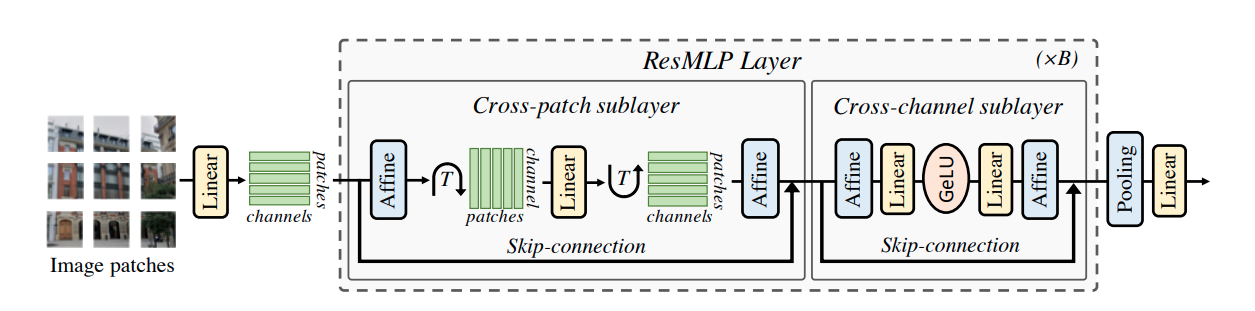

In [34]:
#Affine transformation used in the paper Affα,β(x) = α x + β
class Affine(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(1, 1, num_features))
        self.beta = nn.Parameter(torch.zeros(1, 1, num_features))

    def forward(self, x):
        return self.alpha * x + self.beta

#Cross patch sublayer (first block)
class Cross_Patch_Sublayer(nn.Module):
    def __init__(self, num_features, num_patches):
        super().__init__()
        self.aff1 = Affine(num_features)
        self.fc = nn.Linear(num_patches, num_patches)
        self.aff2 = Affine(num_features)

    def forward(self, x):
        res = x
        x = self.aff1(x)
        x = self.fc(x.transpose(1, 2)).transpose(1, 2)
        x = self.aff2(x)
        out = x + res
        return out

#Cross channel sublayer (second block)
class Cross_Channel_Sublayer(nn.Module):
    def __init__(self, num_features, expansion_factor):
        super().__init__()
        num_hidden = num_features * expansion_factor
        self.aff1 = Affine(num_features)
        self.linear1 = nn.Linear(num_features, num_hidden)
        self.linear2 = nn.Linear(num_hidden, num_features)
        self.aff2 = Affine(num_features)

    def forward(self, x):
        residual = x
        x = self.aff1(x)
        x = self.linear1(x)
        x = F.gelu(x)
        x = self.linear2(x)
        x = self.aff2(x)
        out = x + residual
        return out

#full block of the architecture 
class ResMLPLayer(nn.Module):
    def __init__(self, num_features, num_patches, expansion_factor):
        super().__init__()
        self.cpl = Cross_Patch_Sublayer(num_features, num_patches)
        self.ccl = Cross_Channel_Sublayer(num_features, expansion_factor)

    def forward(self, x):
        x = self.cpl(x)
        out = self.ccl(x)
        return out
  
#Full model 
class ResMLP(nn.Module):
    def __init__( self, image_size = args.img_size, patch_size = args.patch_size, in_channels = args.in_channels, num_features = args.hidden_dim, expansion_factor = args.expansion_factor, num_layers = args.num_layers, num_classes = args.num_classes):
        super().__init__()
        #calculate the number of patches + verify dimensions
        sqrt_num_patches, remainder = divmod(image_size, patch_size)
        assert remainder == 0,     "image is not equally divisable by patch size"
        num_patches = sqrt_num_patches ** 2
        #extract patches
        self.patches = nn.Conv2d(in_channels, num_features, kernel_size=patch_size, stride=patch_size)
        #repeat layers
        self.ResMLP = nn.Sequential(*[ ResMLPLayer(num_features, num_patches, expansion_factor) for _ in range(num_layers)])
        #classification head
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        img_patches = self.patches(x)
        batch_size, num_features, _, _ = img_patches.shape                      # [bs, hidden, patch_size, patch_size]
        img_patches = img_patches.permute(0, 2, 3, 1)                           # [bs, patch_size, patch_size, hidden]
        img_patches = img_patches.view(batch_size, -1, num_features)            # [bs, patch_size*patch_size, hidden]
        h = self.ResMLP(img_patches)
        h = torch.mean(h, dim=1)
        logits = self.classifier(h)
        return logits

#Optimizer 

In [9]:
!pip install tensorboardX
import collections
import math
from tensorboardX import SummaryWriter
from torch.optim import Optimizer

     |████████████████████████████████| 124 kB 8.6 MB/s 


In [10]:
# Reference
# https://github.com/cybertronai/pytorch-lamb

class Lamb(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6,
                 weight_decay=0, adam=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        self.adam = adam
        super(Lamb, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Lamb does not support sparse gradients, consider SparseAdam instad.')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Paper v3 does not use debiasing.
                # bias_correction1 = 1 - beta1 ** state['step']
                # bias_correction2 = 1 - beta2 ** state['step']
                # Apply bias to lr to avoid broadcast.
                step_size = group['lr'] # * math.sqrt(bias_correction2) / bias_correction1

                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)

                adam_step = exp_avg / exp_avg_sq.sqrt().add(group['eps'])
                if group['weight_decay'] != 0:
                    adam_step.add_(p.data, alpha=group['weight_decay'])

                adam_norm = adam_step.pow(2).sum().sqrt()
                if weight_norm == 0 or adam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / adam_norm
                state['weight_norm'] = weight_norm
                state['adam_norm'] = adam_norm
                state['trust_ratio'] = trust_ratio
                if self.adam:
                    trust_ratio = 1

                p.data.add_(adam_step, alpha=-step_size * trust_ratio)

        return loss

#Main

In [45]:
def adjust_learning_rate(optimizer, epoch, args):
    """decay the lr by 10 every 10 epochs"""
    lr = args.lr * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [12]:
def save_checkpoint(best_acc, model, optimizer, args, epoch):
    model_state_dict = model.state_dict()
    torch.save({
        'model_state_dict': model_state_dict,
        'epoch': epoch,
        'optimizer_state_dict': optimizer.state_dict(),
        'acc': best_acc,
    }, os.path.join('checkpoints2', 'checkpoint_model_best.pth'))


In [59]:
def train(epoch, train_loader, model, optimizer, criterion, args):
    #put model into training mode 
    model.train()
    losses = 0.
    acc = 0.
    length = len(train_loader.dataset)
    for i, (data, label) in enumerate(train_loader):
        data, label = data.cuda(), label.cuda()
        #forward pass
        logits = model(data) 
        a, pred = F.softmax(logits, dim=-1).max(1)
        acc += pred.eq(label).sum().item()
        optimizer.zero_grad()
        loss = criterion(logits, label)
        losses += loss
        #backprop
        loss.backward()
        #gradient clipping
        if args.gradient_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.gradient_clip)

        optimizer.step()
        if i % args.print_intervals == 0 and i != 0:
            print('Epoch: {0:4d} ,  \t Loss: {1:.3f}'.format(epoch, losses / (i + 1)))

    return losses / (i + 1)


In [61]:
def evalu(epoch, data_loader, model, args):
    #put model into eval mode 
    model.eval()
    acc = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            _, pred = F.softmax(output, dim=-1).max(1)
            acc += pred.eq(target).sum().item()

    return acc / len(data_loader.dataset) * 100.


In [62]:
model = ResMLP()
optimizer = Lamb(model.parameters(), lr=args.lr, weight_decay=args.weight_decay, betas=(.9, .999))

model = model.cuda()

if not os.path.isdir('checkpoints2'):
  os.mkdir('checkpoints2')

if args.checkpoints is not None:
    checkpoints = torch.load(os.path.join('checkpoints', args.checkpoints))
    model.load_state_dict(checkpoints['model_state_dict'])
    optimizer.load_state_dict(checkpoints['optimizer_state_dict'])
    start_epoch = checkpoints['epoch']
    print("Best acc: {}".format(checkpoints['acc']))
else:
    start_epoch = 1

if args.train:
  criterion = nn.CrossEntropyLoss()
  lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.0001)       #delete and try with optimizer step

  prev_best_acc = 0
  train_loss = []
  train_acc = []
  test_acc= [] 
  for epoch in range(start_epoch, args.epochs + 1):
      loss = train(epoch, train_loader, model, optimizer, criterion, args)
      train_loss.append(loss)


      curr_train_acc = evalu(epoch, train_loader, model, args)
      train_acc.append(curr_train_acc)
      print('[Epoch: {0:4d}], \t \t Train Acc: {1:.3f}'.format(epoch, curr_train_acc ))
        

      curr_test_acc = evalu(epoch, test_loader, model, args)
      test_acc.append(curr_test_acc)
      print('[Epoch: {0:4d}], \t \t Test Acc: {1:.3f}'.format(epoch, curr_test_acc ))
        

      if prev_best_acc < curr_acc:
          prev_best_acc = curr_acc
          save_checkpoint(curr_acc, model, optimizer, args, epoch)
      adjust_learning_rate(optimizer, epoch, args)

else:
    evalu(start_epoch, test_loader, model, args)

Epoch:    1 ,  	 Loss: 2.405
Epoch:    1 ,  	 Loss: 2.263
Epoch:    1 ,  	 Loss: 2.163
Epoch:    1 ,  	 Loss: 2.086
Epoch:    1 ,  	 Loss: 2.027
Epoch:    1 ,  	 Loss: 1.975
Epoch:    1 ,  	 Loss: 1.929
Epoch:    1 ,  	 Loss: 1.887
Epoch:    1 ,  	 Loss: 1.854
Epoch:    1 ,  	 Loss: 1.822
Epoch:    1 ,  	 Loss: 1.796
Epoch:    1 ,  	 Loss: 1.769
Epoch:    1 ,  	 Loss: 1.744
Epoch:    1 ,  	 Loss: 1.722
Epoch:    1 ,  	 Loss: 1.703
[Epoch:    1], 	 	 Train Acc: 50.032
[Epoch:    1], 	 	 Test Acc: 52.210
Epoch:    2 ,  	 Loss: 1.375
Epoch:    2 ,  	 Loss: 1.371
Epoch:    2 ,  	 Loss: 1.374
Epoch:    2 ,  	 Loss: 1.372
Epoch:    2 ,  	 Loss: 1.373
Epoch:    2 ,  	 Loss: 1.372
Epoch:    2 ,  	 Loss: 1.366
Epoch:    2 ,  	 Loss: 1.360
Epoch:    2 ,  	 Loss: 1.355
Epoch:    2 ,  	 Loss: 1.349
Epoch:    2 ,  	 Loss: 1.344
Epoch:    2 ,  	 Loss: 1.342
Epoch:    2 ,  	 Loss: 1.336
Epoch:    2 ,  	 Loss: 1.335
Epoch:    2 ,  	 Loss: 1.331
[Epoch:    2], 	 	 Train Acc: 56.380
[Epoch:    2], 	 	 T

KeyboardInterrupt: ignored

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

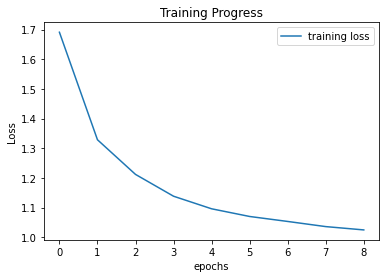

In [71]:
x = np.arange(len(train_loss))
plt.plot(x, train_loss, label='training loss')


plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Training Progress")
plt.legend(loc='upper right', frameon=True)
plt.show()

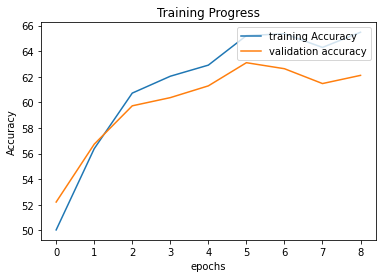

In [70]:
x = np.arange(len(train_acc))
plt.plot(x, train_acc, label='training Accuracy')
plt.plot(x, test_acc, label='validation accuracy')

plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Training Progress")
plt.legend(loc='upper right', frameon=True)
plt.show()